In [ ]:
#default_exp models

In [ ]:
#export
from fastai.text.all import *
from fastai.vision.all import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# Models
> Here we define the different models

## Utility layers
Simple functionalities for the models.

In [ ]:
#export
def mask_normalisation(x, mask):
    "Normalises each trajectory without taking the mask into account"
    lens = x.shape[1] - mask.sum(dim=1) + 1
    x_with_0 = x.masked_fill(mask, 0)
    mean = x_with_0.sum(dim=1).div_(lens.type(x_with_0.type()))
    x_diff = (x - mean.unsqueeze(-1)).masked_fill(mask, 0)
    sd = x_diff.pow(2).sum(1).div(lens.type(x_with_0.type()) - 1).sqrt()
    return x_diff.div_(sd.unsqueeze(-1))

def mask_concat_pool(output, mask):
    "Pool output of RNN with padding mask into one tensor [last_pool, avg_pool, max_pool]"
    lens = output.shape[1] - mask.sum(dim=1) + 1
    out_with_0 = output.masked_fill(mask, 0)
    out_with_inf = output.masked_fill(mask, -float('inf'))
    avg_pool = out_with_0.sum(dim=1).div_(lens.type(out_with_0.type()))
    max_pool = out_with_inf.max(dim=1)[0]
    return torch.cat([output[:, -1], avg_pool, max_pool], 1)

def get_act(vocab_sz, yrange=None):
    "Provides activation according to regression or classification task."
    if vocab_sz == 1:
        yrange = (0, 2.05) if yrange is None else yrange
        act = SigmoidRange(*yrange)
    else:
        act = nn.Softmax(dim=1)
    return act

def custom_splitter(m):
    "Splits model into parts for freezing. The model should have a `.blocks` property."
    return L([block for block in m.blocks]).map(params)

def custom_f1(y_pred, y, avg='micro'): 
    "F1 score with activation and prediction to train with `CrossEntropyFlat`"
    return F1Score(average=avg)(y_pred.softmax(1).argmax(1), y)

class Permute(Module):
    def forward(self, x): return x.permute(0, 2, 1)

## Learner

A `Learner` is a characteristic object in fastai that handles the learning process of a given model. We'll make our own learners accounting for our needs in order to minimize the amount of code. 

In [ ]:
#export
@delegates(Learner.__init__)
class MyLearner(Learner):
    def __init__(self, dls, model, splitter=custom_splitter, path=Path(".."), **kwargs):
        super().__init__(dls, model, splitter=splitter, path=path, **kwargs)
    
@delegates(Learner.__init__)
class RNNLearner(Learner): 
    def __init__(self, dls, model, alpha=2., beta=1., splitter=custom_splitter, path=Path(".."), moms=(0.8,0.7,0.8), **kwargs):
        super().__init__(dls, model, splitter=splitter, moms=moms, path=path, **kwargs)
        self.add_cbs([RNNRegularizer(alpha=alpha, beta=beta)])

## Model for baseline

The most basic model is one that takes the dataset and predicts the mean. Better start low, let's see what we get. 

In [ ]:
#export
class MeanPredict:
    def __init__(self):
        self.mean = 0
        
    def fit(self, y): self.mean = y.mean()
    def predict(self, x): return torch.ones(x.shape[0]) * self.mean

In [ ]:
#hide
from andi_unicorns.data import load_data

In [ ]:
df = load_data(task=1, dim=1)
x, y = df.loc[:, 'x'], df.loc[:, 'y']

In [ ]:
cut = int(x.shape[0]*0.2)
x_train, x_test = x[cut:], x[:cut]
y_train, y_test = y[cut:], y[:cut]

In [ ]:
mean_model = MeanPredict()
mean_model.fit(y_train)

In [ ]:
preds = mean_model.predict(x_test)
MAE = (tensor(y_test) - preds).abs().mean().item()
MAE

0.49662789702415466

## Dense classifier

Generic classifier based on fully connected layers. 

In [ ]:
#export
class Classifier(Module):
    "Dense classifier"
    def __init__(self, dims, ps, act=True, yrange=None):
        if len(ps) != len(dims)-1: raise ValueError(f"Number of layers {len(dims)} and dropout values {len(ps)} don't match.")
        acts = [nn.ReLU(inplace=True)] * (len(dims) - 2) + [None]
        layers = [LinBnDrop(i, o, p=p, act=a) for i,o,p,a in zip(dims[:-1], dims[1:], ps, acts)]
        if act: layers.append(get_act(dims[-1], yrange=yrange))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): return self.layers(x)
    
class PoolingClassifier(Classifier):
    "Pooling linear classifier inspired by `PoolingLinearClassifier`"
    def forward(self, x):
        out, mask = x
        x = mask_concat_pool(out, mask)
        x = self.layers(x)
        return x, out, out

## Baseline LSTM

Simplest possible LSTM to have a starting point. After the LSTM there's a (badly implemented) average pooling.

In [ ]:
#export
class SimpleLSTM(Module):
    "Cheap and simple LSTM running through the trajectories."
    def __init__(self, dim, h_size, vocab_sz, bs, n_layers=1, yrange=(0, 2.05)):
        self.rnn = nn.LSTM(dim, h_size, n_layers, batch_first=True)
        self.h_o = nn.Linear(h_size, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, h_size) for _ in range(2)] # In case we do a generative
        self.sigmoid = SigmoidRange(*yrange)
        
    def forward(self, x):
        res, h = self.rnn(x) # res[bs, len, h_size], 
        self.h = [h_.detach() for h_ in h]
        avg_pool = res.mean(1)   # Poorly done avg pooling
        out = self.h_o(avg_pool)
        return self.sigmoid(out).squeeze()
    
    def reset(self): 
        for h in self.h: h.zero_()

In [ ]:
#hide
from andi_unicorns.data import get_discriminative_dls

In [ ]:
bs = 512
dls = get_discriminative_dls(1, dim=1, bs=bs)
my_lstm = SimpleLSTM(dim=1, h_size=200, n_layers=2, vocab_sz=1, bs=bs)

In [ ]:
learn = Learner(dls, my_lstm, loss_func=L1LossFlat(), path=Path(".."))

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=1.5848932266235352)

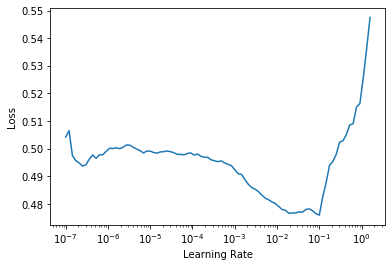

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,0.480675,0.457632,00:06
1,0.469124,0.455228,00:06
2,0.459526,0.455297,00:06
3,0.456676,0.458143,00:06
4,0.455993,0.452877,00:06
5,0.452940,0.450441,00:06
6,0.453736,0.451169,00:06
7,0.452826,0.452540,00:06
8,0.449670,0.453951,00:06
9,0.443756,0.438794,00:06


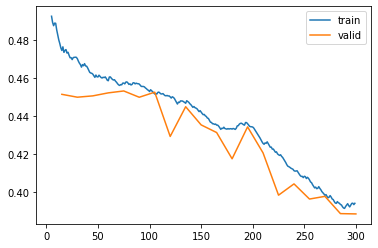

In [ ]:
learn.recorder.plot_loss()

## LSTM with concat pooling
LSTM concatenating last, average and max pooling for the linear layer. Missing: dropout, RNN regularization and batch norm.

In [ ]:
#export
class ConcatPoolLSTM(Module):
    "LSTM with last, avg & max pooling."
    def __init__(self, dim, h_size, vocab_sz, n_layers=1, bidir=False, yrange=(0, 2.05), pad_value=0):
        self.pad_value = pad_value
        self.rnn = nn.LSTM(dim, h_size, n_layers, batch_first=True, bidirectional=bidir)
        self.h_o = nn.Linear(3*h_size, vocab_sz)
        self.sigmoid = SigmoidRange(*yrange)
        
    def forward(self, x):
        res, h = self.rnn(x)
        for h_ in h: h_.detach()
        mask = x == self.pad_value
        pool = mask_concat_pool(res, mask)
        out = self.h_o(pool)
        return self.sigmoid(out).squeeze()    

In [ ]:
#hide
from andi_unicorns.data import get_discriminative_dls

In [ ]:
bs = 256
dls = get_discriminative_dls(1, dim=1, bs=bs)
my_lstm = ConcatPoolLSTM(dim=1, h_size=200, vocab_sz=1, n_layers=2)

In [ ]:
learn = Learner(dls, my_lstm, loss_func=L1LossFlat(), path=Path(".."))

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=6.309573450380412e-07)

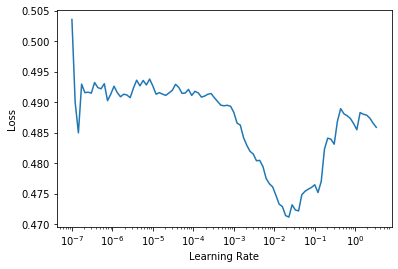

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=2e-3)

epoch,train_loss,valid_loss,time
0,0.477336,0.463557,00:05
1,0.453745,0.438139,00:05
2,0.441699,0.434306,00:05
3,0.433865,0.403646,00:05
4,0.410418,0.348553,00:05
5,0.380282,0.333734,00:05
6,0.357164,0.334694,00:05
7,0.343448,0.310950,00:05
8,0.329999,0.309211,00:05
9,0.320462,0.301743,00:04


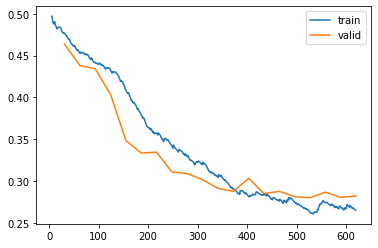

In [ ]:
learn.recorder.plot_loss()

## LSTM with regularization

Adding regularization to the previous model in the form of dropout and adding batch norm to the linear layers. 

In [ ]:
#export
class RegLSTMLin(Module):
    "LSTM with dropout and batch norm."
    def __init__(self, dim, h_size, vocab_sz=1, rnn_layers=1, in_p=0.4, hid_p=0.3, weight_p=0.5, out_ps=0.4, linear_layers=[200, 50], ps=None,   
                 bidir=False, layer='LSTM', act=True, norm=False, yrange=(0, 2.05), pad_value=0):
        store_attr('norm,pad_value')
        self.rnn = RegLSTM(dim, h_size, rnn_layers, hidden_p=hid_p, input_p=in_p, weight_p=weight_p, bidir=bidir, layer=layer)
        
        lin_dim = [h_size*3] + linear_layers + [vocab_sz]
        if ps is None: ps = [0.1]*len(linear_layers)
        ps = [out_ps] + ps
        self.linear = PoolingClassifier(lin_dim, ps=ps, act=act, yrange=yrange)
        self.blocks = [self.rnn, self.linear]
        
    def forward(self, x):
        mask = x == self.pad_value
        if self.norm: x = mask_normalisation(x, mask)
        out = self.rnn(x)
        x, out, out = self.linear((out, mask))
        return x, out, out 
    
class RegLSTM(Module):
    "LSTM with regularization and inter-layer dropout."
    def __init__(self, dim, n_hid, n_layers, input_p=0.4, hidden_p=0.3, weight_p=0.5, bidir=False, layer='LSTM'):
        store_attr('dim,n_hid,n_layers,layer')
        self.n_dir = 2 if bidir else 1
        self.rnns = nn.ModuleList([self._one_rnn(dim if l == 0 else n_hid, n_hid//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, x):
        output = self.input_dp(x)
        new_hidden = []
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            output, new_h = rnn(output)
            to_detach(new_h, cpu=False, gather=False)
            if l != self.n_layers-1: output = hid_dp(output)
        return output

    def _one_rnn(self, n_in, n_out, bidir, weight_p, l):
        "Return one of the inner rnn"
        layer = getattr(nn, self.layer)
        rnn = layer(n_in, n_out, 1, batch_first=True, bidirectional=bidir)
        return WeightDropout(rnn, weight_p)        

In [ ]:
#hide
from andi_unicorns.data import get_discriminative_dls

In [ ]:
dim = 1
bs = 128
dls = get_discriminative_dls(2, dim=1, bs=bs)
my_lstm = RegLSTMLin(dim=dim, vocab_sz=5, h_size=500, rnn_layers=2, in_p=0., hid_p=0.3, weight_p=0.05, out_ps=0.3, 
                     linear_layers=[500, 200, 50], ps=[0.4, 0.4, 0.4], act=False)

learn = RNNLearner(dls, my_lstm, loss_func=CrossEntropyLossFlat(), metrics=custom_f1)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.015848932787775993)

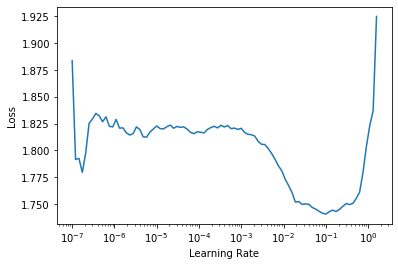

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, lr_max=5e-3, wd=1e-3)

epoch,train_loss,valid_loss,custom_f1,time
0,1.704521,1.591073,0.262000,00:13
1,1.595931,1.475284,0.338500,00:13
2,1.479173,1.784336,0.248500,00:15
3,1.387651,1.495931,0.383500,00:13
4,1.236572,1.424089,0.398500,00:13
5,1.095731,1.096087,0.547500,00:13
6,1.017265,1.003676,0.566000,00:14
7,0.993526,0.950899,0.589000,00:14
8,0.920857,0.981660,0.568500,00:13
9,1.396451,1.756910,0.194500,00:13


In [ ]:
learn.recorder.plot_loss()

## Convolutional networks

Convolutional neural networks (CNNs) are, generally, built of blocks of several convolutional layers. We take the `XResNet` model from fastai to perform our prototyping.

In [ ]:
#export
class CustomXResNet(nn.Sequential):    
    @delegates(ResBlock)
    def __init__(self, block, expansion, layers, p=0.0, c_in=1, n_out=1000, stem_szs=(32,32,64),
                 widen=1.0, sa=False, act_cls=defaults.activation, ndim=1, ks=3, stride=2, **kwargs):
        store_attr('block,expansion,act_cls,ndim,ks')
        if ks % 2 == 0: raise Exception('kernel size has to be odd!')
        stem_szs = [c_in, *stem_szs]
        stem = [ConvLayer(stem_szs[i], stem_szs[i+1], ks=ks, stride=stride if i==0 else 1,
                          act_cls=act_cls, ndim=ndim)
                for i in range(len(stem_szs)-1)]

        n_layers = len(layers)
        block_szs = [stem_szs[-1], 128, 256, 512] + [256]*(n_layers-4)
        block_szs = [int(o*widen) for o in block_szs[:n_layers]]
        block_szs = [stem_szs[-1]//expansion] + block_szs
        blocks    = self._make_blocks(layers, block_szs, sa, stride, **kwargs)

        super().__init__(
            *stem, MaxPool(ks=ks, stride=stride, padding=ks//2, ndim=ndim),
            *blocks, # AdaptiveAvgPool(sz=1, ndim=ndim)
            AdaptiveConcatPool1d(), Flatten(), nn.Dropout(p),
            nn.Linear(2*block_szs[-1]*expansion, n_out),
        )
        init_cnn(self)

    def _make_blocks(self, layers, block_szs, sa, stride, **kwargs):
        return [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l,
                                 stride=1 if i==0 else stride, sa=sa and i==len(layers)-4, **kwargs)
                for i,l in enumerate(layers)]

    def _make_layer(self, ni, nf, blocks, stride, sa, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls, ndim=self.ndim, ks=self.ks, **kwargs)
              for i in range(blocks)])

In [ ]:
#export    
@delegates(CustomXResNet.__init__)
class CNNLin(Module):
    def __init__(self, dim, vocab_sz=1, h_size=1000, yrange=(0, 2.05), exp=1, layers=[1, 1, 1, 1], out_p=0., linear_layers=[200, 50], ps=None, act=True, norm=True, **kwargs):
        self.norm = norm
        self.cnn = CNN(dim, exp=exp, layers=layers, p=out_p, n_out=h_size, **kwargs)
        lin_dim = [h_size] + linear_layers + [vocab_sz]
        if ps is None: ps = [0.1]*len(linear_layers)
        ps = [out_p] + ps
        self.lin = Classifier(lin_dim, ps, act=act, yrange=yrange)
        self.blocks = [self.cnn, self.lin]
        
    def forward(self, x):
        if self.norm: 
            mask = x == 0
            x = mask_normalisation(x, mask)
        x = self.cnn(x.permute(0, 2, 1))
        return self.lin(x)

@delegates(CustomXResNet.__init__)
class CNN(CustomXResNet):
    def __init__(self, dim, exp=1, layers=[1, 1], **kwargs):
        super().__init__(ResBlock, exp, layers, c_in=dim, ndim=1, **kwargs)

In [ ]:
#hide
from andi_unicorns.data import get_custom_dls

In [ ]:
dim = 1
dls = get_custom_dls(target='exp', dim=dim, bs=128)
cnn = CNNLin(dim, h_size=512, layers=[1, 1], ks=3, p=0.5, stem_szs=(32, 64))
learn = MyLearner(dls, cnn, loss_func=L1LossFlat(), metrics=mae)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=7.585775847473997e-07)

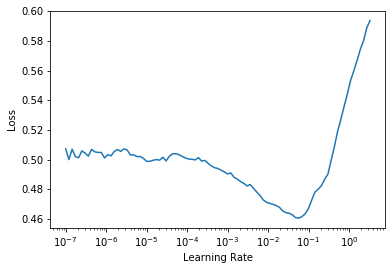

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=5e-3, wd=1e-3)

epoch,train_loss,valid_loss,mae,time
0,0.362033,0.342109,0.342109,00:09
1,0.310369,0.302907,0.302907,00:08
2,0.292476,0.273055,0.273055,00:08
3,0.276008,0.258261,0.258261,00:08
4,0.256228,0.255621,0.255621,00:09
5,0.254321,0.237205,0.237205,00:08
6,0.236969,0.231746,0.231746,00:09
7,0.243301,0.233111,0.233111,00:08
8,0.236128,0.228627,0.228627,00:09
9,0.222612,0.218090,0.218090,00:09


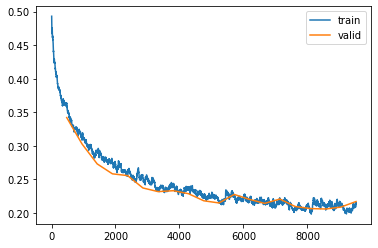

In [ ]:
learn.recorder.plot_loss()

## CNN and RNN
Combining the feature extration power of both approaches with a classifier that feeds on both. 

In [ ]:
#export
class RNNCNNClassifier(Module):
    def __init__(self, dim, vocab_sz=1, rnn_h=750, rnn_layers=1, rnn_layer='GRU', in_p=0.4, rnn_p=0.3, w_p=0.5, out_p=0.4, bidir=False, 
                 cnn_h=512, cnn_exp=1, cnn_layers=[1, 1, 1], cnn_stemsz=(32, 64), cnn_ks=3, cnn_p=0.5, linear_layers=[200, 50], ps=None,
                 act=True, yrange=(0, 2.05), pad_value=0):
        store_attr('pad_value')
        self.rnn = RegLSTMLin(dim, rnn_h, vocab_sz=3*rnn_h, rnn_layers=rnn_layers, in_p=in_p, hid_p=rnn_p, weight_p=w_p, out_ps=out_p, 
                              linear_layers=[], bidir=bidir, act=False)
        self.cnn = CNN(dim, exp=cnn_exp, layers=cnn_layers, p=cnn_p, n_out=cnn_h, stem_szs=cnn_stemsz)
        
        lin_dim = [3*rnn_h + cnn_h] + linear_layers + [vocab_sz]
        if ps is None: ps = [0.2]*len(linear_layers)
        ps = [out_p] + ps
        self.linear = Classifier(lin_dim, ps=ps, act=act, yrange=yrange)
        self.blocks = [self.rnn, self.cnn, self.linear]
        
    def forward(self, x):
        mask = x == self.pad_value
        x = mask_normalisation(x, mask)
        out_rnn, out_cnn = self.rnn(x), self.cnn(x.permute(0, 2, 1))
        x = torch.cat([out_rnn[0].relu_(), out_cnn.relu_()], dim=1)
        x = self.linear(x)
        return x, out_rnn[1], out_rnn[2]

## Ensembles

Ensembles are extremely powerful structures. Here, we build a simple ensemble that takes a bunch of pre-trained models and averages their output for the prediction.

In [ ]:
#export
class Ensemble(Module):
    def __init__(self, models, add_act=False):
        store_attr('models')
        self.act = get_act(self._get_vocab_sz) if add_act else noop
        
    def forward(self, x):
        preds = self._get_preds(x)
        return self._average(preds)
        
    def _get_preds(self, x):
        preds = []
        for model in self.models:
            if hasattr(model, 'rnn'): preds.append(self.act(model(x)[0]))
            else:                     preds.append(self.act(model(x)))
        return preds
    
    @staticmethod
    def _majority_vote(preds): return torch.stack(preds, dim=-1).mean(-1)
    
    def _average(self, preds): return torch.stack(preds, dim=-1).mean(-1)
    
    def _get_vocab_sz(self): return self.models[0].blocks[-1].layers[-1][-1].out_features

In [ ]:
#hide
from andi_unicorns.data import get_custom_dls
from andi_unicorns.utils import load_model

In [ ]:
names = [f"cnn_dim1_t2_ks3_{i}" for i in range(11)]
models = [load_model(name).cuda() for name in names]
dls = get_custom_dls(bs=10)

In [ ]:
ensemble = Ensemble(models, add_act=True)

In [ ]:
xb, yb = dls[0].one_batch()
y_pred = ensemble(xb)
yb, y_pred

(tensor([2, 3, 4, 0, 4, 1, 4, 1, 3, 3], device='cuda:0'),
 tensor([2, 3, 4, 1, 4, 1, 4, 1, 3, 3], device='cuda:0'))

## Hydra

We call it hydra mainly because it's cool, but it's just a way to get pre-trained models, remove their last layer and merge everything together with a contact classifier. Hence, it is, indeed, an inverted hydra with several bodies and one head!

The hydra asumes every body to come with whatever feature extraction and a `Classifier` at the end. The `Classifier` should have, at least, two dense layers, as the `Hydra` drops the last one and uses the previous layer as glue for the contact layer. 

In [ ]:
#export
class Hydra(Module):
    def __init__(self, models, vocab_sz=1, out_ps=0.4, linear_layers=[200, 50], ps=None, act=True, yrange=(0, 2.05)):
        for model in models: self._remove_last_layer(model)
        self.blocks = [model for model in models]
        out_size = sum([self._output_size(block) for block in self.blocks])
        
        lin_dim = [out_size] + linear_layers + [vocab_sz]
        if ps is None: ps = [0.1]*len(linear_layers)
        ps = [out_ps] + ps
        self.linear = Classifier(lin_dim, ps=ps, act=act, yrange=yrange)
        self.blocks += [self.linear]
        
    def forward(self, x):
        outs = self._body_outs(x)
        return self.linear(outs)
    
    def _body_outs(self, x):
        outs = [block(x)[0] if hasattr(block, 'rnn') else block(x) for block in self.blocks[:-1]]
        return torch.cat(outs, dim=1)
    
    def eval(self): 
        for block in self.blocks: block.eval()
            
    def unfreeze_contacts(self): 
        for block in self.blocks[:-1]:
            for p in params(block.blocks[-1]):
                p.requires_grad_(True)
    
    def freeze_contacts(self):
        for block in self.blocks[:-1]:
            for p in params(block.blocks[-1]):
                p.requires_grad_(False)
        
    @staticmethod    
    def _last_layer(model): return model.blocks[-1].layers[-1]
        
    def _remove_last_layer(self, model): 
        if isinstance(self._last_layer(model), SigmoidRange) or isinstance(self._last_layer(model), nn.Softmax): 
            del model.blocks[-1].layers[-2:]
        else:                             
            del model.blocks[-1].layers[-1]
    
    def _output_size(self, model): return self._last_layer(model)[-2].out_features

In [ ]:
names = [f"cnn_dim1_t2_ks3_{i}" for i in range(11)]
models = [load_model(name).cuda() for name in names]
dls = get_custom_dls(bs=10)

In [ ]:
h = Hydra(models[:2], vocab_sz=5).cuda()

In [ ]:
xb, yb = dls[0].one_batch()
y_pred = h(xb)
yb, y_pred.argmax(1)

(tensor([2, 2, 0, 4, 2, 2, 0, 2, 0, 3], device='cuda:0'),
 tensor([2, 0, 3, 1, 2, 0, 2, 4, 1, 0], device='cuda:0'))

# Export-

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_data.ipynb.
Converted 01_models.ipynb.
Converted 02_prototypes.ipynb.
Converted 03_utils.ipynb.
Converted 04_analysis.ipynb.
Converted index.ipynb.
